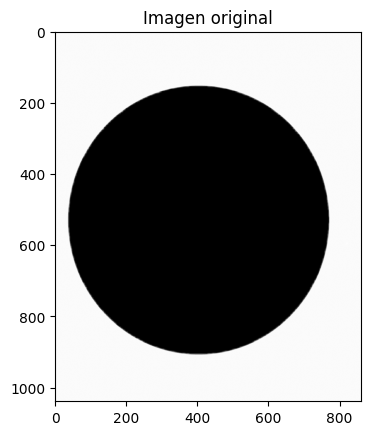

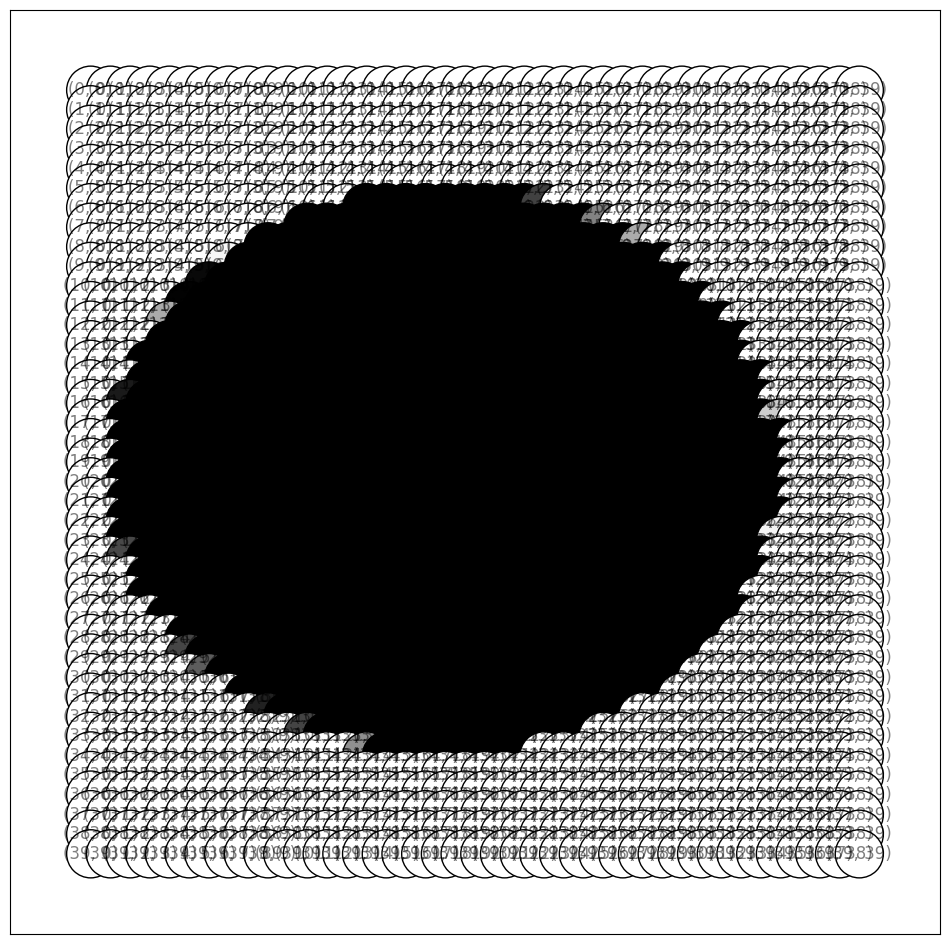

In [29]:
import json
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx #crear grafo
import cv2 #leer imagenes

from qci_client import QciClient
from scipy.sparse import dok_matrix #crear el QUBO 
from qseg.graph_utils import image_to_grid_graph, draw
from qseg.utils import decode_binary_string
from scipy.ndimage import label #post procesado


# Configurar el cliente de QCI
token = "00e16417bba7a1827d109ece01d2bf06"
api_url = "https://api.qci-prod.com"
qclient = QciClient(api_token=token, url=api_url)

# Cargar imagen y convertir a escala de grises
#image_path = r"C:\Users\carlo\TFG\Q-Seg\triangulo.png"
#image_path = r"C:\Users\carlo\TFG\Q-Seg\Carton.jpeg"
image_path = r"C:\Users\carlo\TFG\Q-Seg\circulo.png"
#image_path = r"C:\Users\carlo\TFG\Q-Seg\Negro.jpeg"
#image_path = r"C:\Users\carlo\TFG\Q-Seg\bosque_prueba.png"
#image_path = r"C:\Users\carlo\TFG\Q-Seg\Cuadrado_blanco.jpeg"

image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
if image is None:
    raise ValueError("No se pudo cargar la imagen. Verifica la ruta.")
image = image / 255.0  # Normalizar valores entre 0 y 1
height, width = image.shape

plt.imshow(image, cmap='gray')
plt.title("Imagen original")
plt.show()

# Redimensionar la imagen antes de crear el grafo
target_size = (40, 40)
image_resized = cv2.resize(image, target_size)

# Crear grafo con la imagen redimensionada
normalized_nx_elist = image_to_grid_graph(image_resized)
G = nx.grid_2d_graph(image_resized.shape[0], image_resized.shape[1])
G.add_weighted_edges_from(normalized_nx_elist)
height, width = image_resized.shape
draw(G, image_resized)

2025-06-05 10:01:21 - Dirac allocation balance = 362 s
2025-06-05 10:01:22 - Job submitted: job_id='68414ed1b8b42e8edbee7839'
2025-06-05 10:01:22 - QUEUED
2025-06-05 10:01:24 - RUNNING
2025-06-05 11:05:03 - COMPLETED
2025-06-05 11:05:06 - Dirac allocation balance = -3308 s


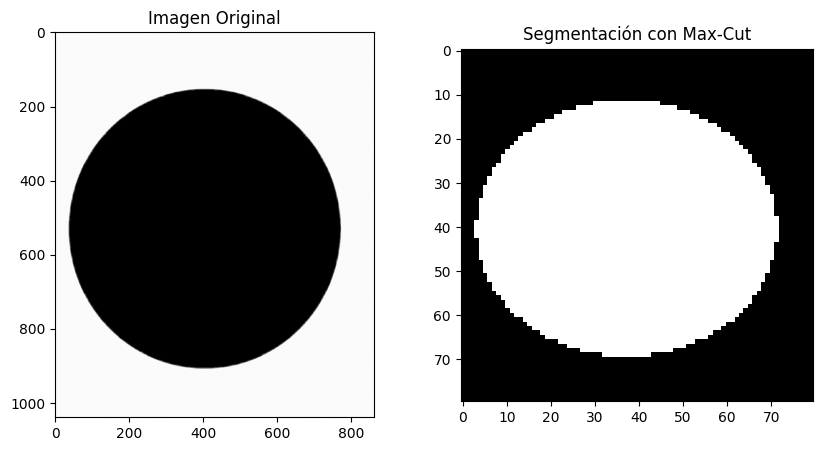

In [28]:
# Construcción del QUBO para Max-Cut 
node_mapping = {node: i for i, node in enumerate(G.nodes)}
num_nodes = len(G.nodes)
qubo_matrix = dok_matrix((num_nodes, num_nodes), dtype=np.float32)

# Matriz de adyacencia invertida para maximización
adj_matrix = -1 * nx.to_scipy_sparse_array(G).toarray()  # Inversión para maximización
# Términos cuadráticos (basados en la matriz de adyacencia)
for i in range(num_nodes):
    for j in range(i + 1, num_nodes):
        weight = adj_matrix[i, j]
        if weight != 0:
            qubo_matrix[i, j] += weight
            qubo_matrix[j, i] += weight

# guía según la intensidad (ajustable)
alpha = 500.0
for node in G.nodes:
    i = node_mapping[node]
    intensity = image_resized[node[0], node[1]]
    qubo_matrix[i, i] += alpha * (2 * intensity - 1)

# Convertir la matriz QUBO a formato numpy y enviarla a QCI
qubo_numpy = qubo_matrix.toarray()
qubo_data = {"file_name": "qubo_data.json", "file_config": {"qubo": {"data": qubo_numpy}}}

try:
    response_json = qclient.upload_file(file=qubo_data)
except Exception as e:
    print(f"Error al subir el archivo a QCI: {e}")
    exit(1)

# Enviar trabajo a QCI
job_body = qclient.build_job_body(
    job_type="sample-qubo",
    qubo_file_id=response_json["file_id"],
    job_params={"device_type": "dirac-1", "num_samples": 1}
)
try:
    job_response = qclient.process_job(job_body=job_body)
except Exception as e:
    print(f"Error al procesar el trabajo en QCI: {e}")
    exit(1)
    
# Seleccionar la mejor solución
solutions = job_response["results"]["solutions"]
energies = job_response["results"]["energies"]
best_solution = solutions[np.argmin(energies)]
solution_binary_string = [int(best_solution[node_mapping[node]]) for node in G.nodes]


# Decodificación
segmentation_mask = decode_binary_string(solution_binary_string, image_resized.shape[0], image_resized.shape[1])# Post-procesamiento

# Visualización
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(image, cmap=plt.cm.gray)
plt.title("Imagen Original")
plt.subplot(1, 2, 2)
plt.imshow(segmentation_mask, cmap=plt.cm.gray)
plt.title("Segmentación con Max-Cut")
plt.show()

2025-06-04 12:26:21 - Dirac allocation balance = 600 s
2025-06-04 12:26:22 - Job submitted: job_id='68401f4eb8b42e8edbee7403'
2025-06-04 12:26:22 - QUEUED
2025-06-04 12:26:24 - RUNNING
2025-06-04 12:28:00 - COMPLETED
2025-06-04 12:28:03 - Dirac allocation balance = 526 s


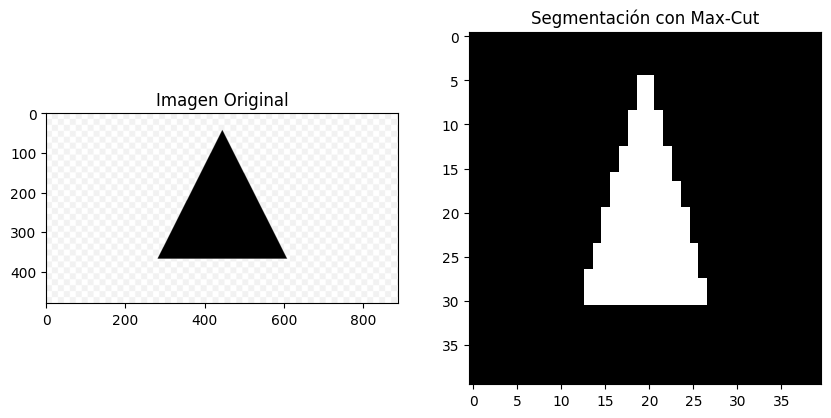

In [2]:
# Construcción del QUBO para Max-Cut 
node_mapping = {node: i for i, node in enumerate(G.nodes)}
num_nodes = len(G.nodes)
qubo_matrix = dok_matrix((num_nodes, num_nodes), dtype=np.float32)

# Matriz de adyacencia invertida para maximización
adj_matrix = -1 * nx.to_scipy_sparse_array(G).toarray()  # Inversión para maximización
# Términos cuadráticos (basados en la matriz de adyacencia)
for i in range(num_nodes):
    for j in range(i + 1, num_nodes):
        weight = adj_matrix[i, j]
        if weight != 0:
            qubo_matrix[i, j] += weight
            qubo_matrix[j, i] += weight

# guía según la intensidad (ajustable)
alpha = 30.0
for node in G.nodes:
    i = node_mapping[node]
    intensity = image_resized[node[0], node[1]]
    qubo_matrix[i, i] += alpha * (2 * intensity - 1)

# Convertir la matriz QUBO a formato numpy y enviarla a QCI
qubo_numpy = qubo_matrix.toarray()
qubo_data = {"file_name": "qubo_data.json", "file_config": {"qubo": {"data": qubo_numpy}}}

try:
    response_json = qclient.upload_file(file=qubo_data)
except Exception as e:
    print(f"Error al subir el archivo a QCI: {e}")
    exit(1)

# Enviar trabajo a QCI
job_body = qclient.build_job_body(
    job_type="sample-qubo",
    qubo_file_id=response_json["file_id"],
    job_params={"device_type": "dirac-1", "num_samples": 1}
)
try:
    job_response = qclient.process_job(job_body=job_body)
except Exception as e:
    print(f"Error al procesar el trabajo en QCI: {e}")
    exit(1)
    
# Seleccionar la mejor solución
solutions = job_response["results"]["solutions"]
energies = job_response["results"]["energies"]
best_solution = solutions[np.argmin(energies)]
solution_binary_string = [int(best_solution[node_mapping[node]]) for node in G.nodes]


# Decodificación
segmentation_mask = decode_binary_string(solution_binary_string, image_resized.shape[0], image_resized.shape[1])# Post-procesamiento

# Visualización
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(image, cmap=plt.cm.gray)
plt.title("Imagen Original")
plt.subplot(1, 2, 2)
plt.imshow(segmentation_mask, cmap=plt.cm.gray)
plt.title("Segmentación con Max-Cut")
plt.show()

2025-05-12 19:34:38 - Dirac allocation balance = 192 s
2025-05-12 19:34:38 - Job submitted: job_id='6822312b7022694b835c0000'
2025-05-12 19:34:38 - RUNNING
2025-05-12 19:34:54 - COMPLETED
2025-05-12 19:34:57 - Dirac allocation balance = 187 s


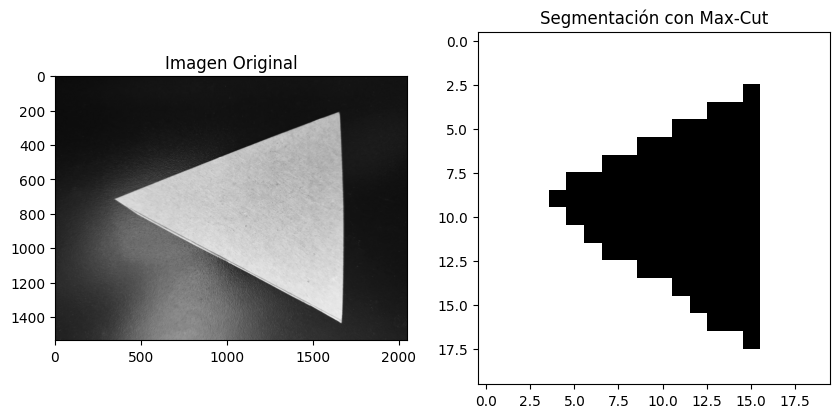

In [5]:
# Construcción del QUBO para Max-Cut 
node_mapping = {node: i for i, node in enumerate(G.nodes)}
num_nodes = len(G.nodes)
qubo_matrix = dok_matrix((num_nodes, num_nodes), dtype=np.float32)

# Matriz de adyacencia invertida para maximización
adj_matrix = -1 * nx.to_scipy_sparse_array(G).toarray()  # Inversión para maximización
# Términos cuadráticos (basados en la matriz de adyacencia)
for i in range(num_nodes):
    for j in range(i + 1, num_nodes):
        weight = adj_matrix[i, j]
        if weight != 0:
            qubo_matrix[i, j] += weight
            qubo_matrix[j, i] += weight

# guía según la intensidad (ajustable)
alpha = 30.0
for node in G.nodes:
    i = node_mapping[node]
    intensity = image_resized[node[0], node[1]]
    qubo_matrix[i, i] += alpha * (2 * intensity - 1)

# Convertir la matriz QUBO a formato numpy y enviarla a QCI
qubo_numpy = qubo_matrix.toarray()
qubo_data = {"file_name": "qubo_data.json", "file_config": {"qubo": {"data": qubo_numpy}}}

try:
    response_json = qclient.upload_file(file=qubo_data)
except Exception as e:
    print(f"Error al subir el archivo a QCI: {e}")
    exit(1)

# Enviar trabajo a QCI
job_body = qclient.build_job_body(
    job_type="sample-qubo",
    qubo_file_id=response_json["file_id"],
    job_params={"device_type": "dirac-1", "num_samples": 1}
)
try:
    job_response = qclient.process_job(job_body=job_body)
except Exception as e:
    print(f"Error al procesar el trabajo en QCI: {e}")
    exit(1)
    
# Seleccionar la mejor solución
solutions = job_response["results"]["solutions"]
energies = job_response["results"]["energies"]
best_solution = solutions[np.argmin(energies)]
solution_binary_string = [int(best_solution[node_mapping[node]]) for node in G.nodes]


# Decodificación
segmentation_mask = decode_binary_string(solution_binary_string, image_resized.shape[0], image_resized.shape[1])# Post-procesamiento

# Visualización
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(image, cmap=plt.cm.gray)
plt.title("Imagen Original")
plt.subplot(1, 2, 2)
plt.imshow(segmentation_mask, cmap=plt.cm.gray)
plt.title("Segmentación con Max-Cut")
plt.show()

2025-05-11 12:53:31 - Dirac allocation balance = 341 s
2025-05-11 12:53:31 - Job submitted: job_id='682081a97022694b835bffee'
2025-05-11 12:53:32 - QUEUED
2025-05-11 12:53:34 - RUNNING
2025-05-11 12:55:07 - COMPLETED
2025-05-11 12:55:09 - Dirac allocation balance = 267 s


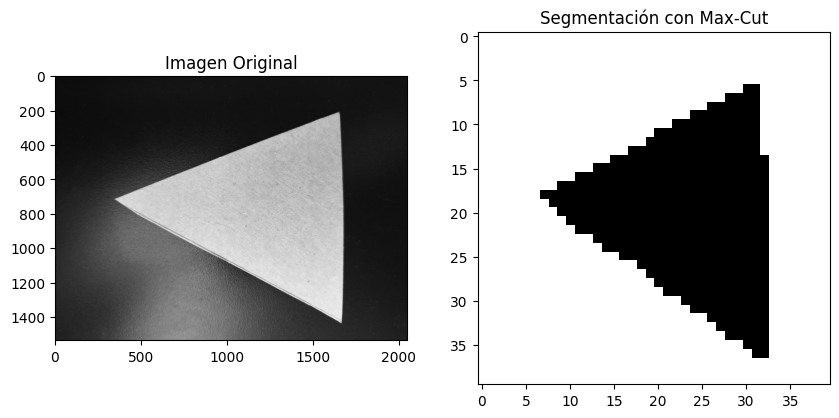

In [10]:
# Construcción del QUBO para Max-Cut 
node_mapping = {node: i for i, node in enumerate(G.nodes)}
num_nodes = len(G.nodes)
qubo_matrix = dok_matrix((num_nodes, num_nodes), dtype=np.float32)

# Matriz de adyacencia invertida para maximización
adj_matrix = -1 * nx.to_scipy_sparse_array(G).toarray()  # Inversión para maximización
# Términos cuadráticos (basados en la matriz de adyacencia)
for i in range(num_nodes):
    for j in range(i + 1, num_nodes):
        weight = adj_matrix[i, j]
        if weight != 0:
            qubo_matrix[i, j] += weight
            qubo_matrix[j, i] += weight

# guía según la intensidad (ajustable)
alpha = 30.0
for node in G.nodes:
    i = node_mapping[node]
    intensity = image_resized[node[0], node[1]]
    qubo_matrix[i, i] += alpha * (2 * intensity - 1)

# Convertir la matriz QUBO a formato numpy y enviarla a QCI
qubo_numpy = qubo_matrix.toarray()
qubo_data = {"file_name": "qubo_data.json", "file_config": {"qubo": {"data": qubo_numpy}}}

try:
    response_json = qclient.upload_file(file=qubo_data)
except Exception as e:
    print(f"Error al subir el archivo a QCI: {e}")
    exit(1)

# Enviar trabajo a QCI
job_body = qclient.build_job_body(
    job_type="sample-qubo",
    qubo_file_id=response_json["file_id"],
    job_params={"device_type": "dirac-1", "num_samples": 1}
)
try:
    job_response = qclient.process_job(job_body=job_body)
except Exception as e:
    print(f"Error al procesar el trabajo en QCI: {e}")
    exit(1)
    
# Seleccionar la mejor solución
solutions = job_response["results"]["solutions"]
energies = job_response["results"]["energies"]
best_solution = solutions[np.argmin(energies)]
solution_binary_string = [int(best_solution[node_mapping[node]]) for node in G.nodes]


# Decodificación
segmentation_mask = decode_binary_string(solution_binary_string, image_resized.shape[0], image_resized.shape[1])

# Post-procesamiento
labeled_mask, num_features = label(segmentation_mask)
if num_features > 0:
    sizes = np.bincount(labeled_mask.ravel())[1:]
    largest_label = np.argmax(sizes) + 1
    segmentation_mask = (labeled_mask == largest_label).astype(float)

# Visualización
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(image, cmap=plt.cm.gray)
plt.title("Imagen Original")
plt.subplot(1, 2, 2)
plt.imshow(segmentation_mask, cmap=plt.cm.gray)
plt.title("Segmentación con Max-Cut")
plt.show()

2025-05-11 12:50:46 - Dirac allocation balance = 346 s
2025-05-11 12:50:46 - Job submitted: job_id='682081047022694b835bffed'
2025-05-11 12:50:47 - QUEUED
2025-05-11 12:50:49 - RUNNING
2025-05-11 12:51:03 - COMPLETED
2025-05-11 12:51:05 - Dirac allocation balance = 341 s


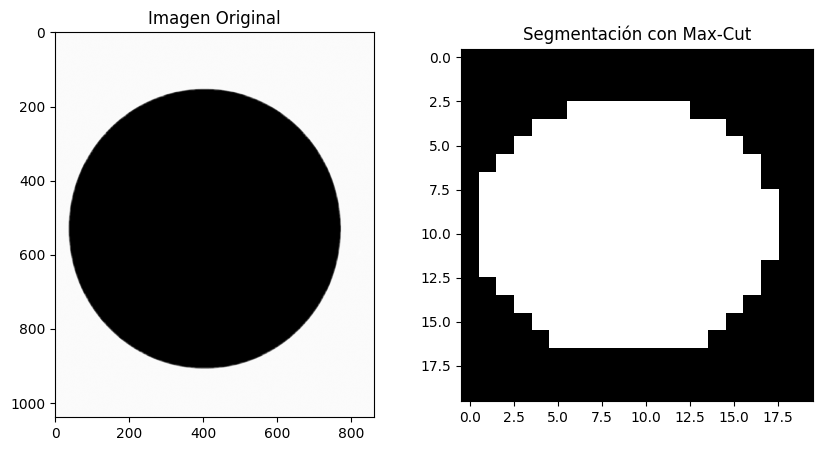

In [8]:
# Construcción del QUBO para Max-Cut 
node_mapping = {node: i for i, node in enumerate(G.nodes)}
num_nodes = len(G.nodes)
qubo_matrix = dok_matrix((num_nodes, num_nodes), dtype=np.float32)

# Matriz de adyacencia invertida para maximización
adj_matrix = -1 * nx.to_scipy_sparse_array(G).toarray()  # Inversión para maximización
# Términos cuadráticos (basados en la matriz de adyacencia)
for i in range(num_nodes):
    for j in range(i + 1, num_nodes):
        weight = adj_matrix[i, j]
        if weight != 0:
            qubo_matrix[i, j] += weight
            qubo_matrix[j, i] += weight

# Término unario: guía según la intensidad (opcional, ajustable)
alpha = 30.0
for node in G.nodes:
    i = node_mapping[node]
    intensity = image_resized[node[0], node[1]]
    qubo_matrix[i, i] += alpha * (2 * intensity - 1)

# Convertir la matriz QUBO a formato numpy y enviarla a QCI
qubo_numpy = qubo_matrix.toarray()
qubo_data = {"file_name": "qubo_data.json", "file_config": {"qubo": {"data": qubo_numpy}}}
try:
    response_json = qclient.upload_file(file=qubo_data)
except Exception as e:
    print(f"Error al subir el archivo a QCI: {e}")
    exit(1)

# Enviar trabajo a QCI
job_body = qclient.build_job_body(
    job_type="sample-qubo",
    qubo_file_id=response_json["file_id"],
    job_params={"device_type": "dirac-1", "num_samples": 1}
)
try:
    job_response = qclient.process_job(job_body=job_body)
except Exception as e:
    print(f"Error al procesar el trabajo en QCI: {e}")
    exit(1)
# Seleccionar la mejor solución
solutions = job_response["results"]["solutions"]
energies = job_response["results"]["energies"]
best_solution = solutions[np.argmin(energies)]
solution_binary_string = [int(best_solution[node_mapping[node]]) for node in G.nodes]


# Decodificación
segmentation_mask = decode_binary_string(solution_binary_string, image_resized.shape[0], image_resized.shape[1])# Post-procesamiento
labeled_mask, num_features = label(segmentation_mask)
if num_features > 0:
    sizes = np.bincount(labeled_mask.ravel())[1:]
    largest_label = np.argmax(sizes) + 1
    segmentation_mask = (labeled_mask == largest_label).astype(float)

# Visualización
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(image, cmap=plt.cm.gray)
plt.title("Imagen Original")
plt.subplot(1, 2, 2)
plt.imshow(segmentation_mask, cmap=plt.cm.gray)
plt.title("Segmentación con Max-Cut")
plt.show()

2025-05-12 19:21:55 - Dirac allocation balance = 267 s
2025-05-12 19:21:55 - Job submitted: job_id='68222e307022694b835bffff'
2025-05-12 19:21:55 - QUEUED
2025-05-12 19:21:58 - RUNNING
2025-05-12 19:23:32 - COMPLETED
2025-05-12 19:23:34 - Dirac allocation balance = 192 s


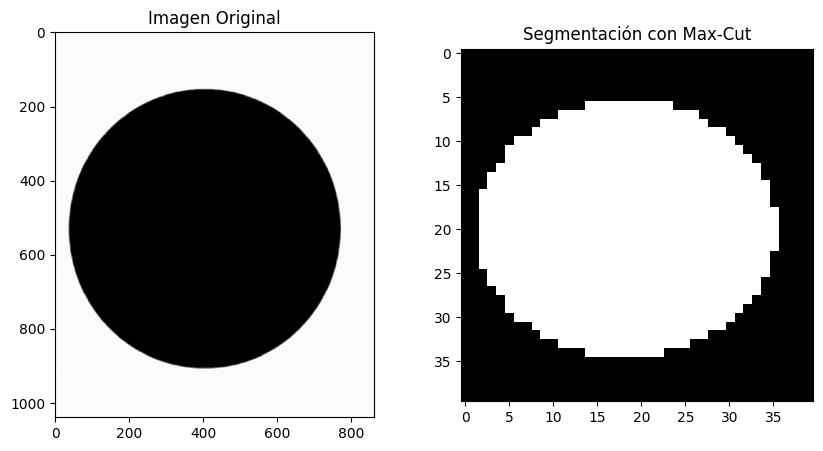

In [2]:
# Construcción del QUBO para Max-Cut 
node_mapping = {node: i for i, node in enumerate(G.nodes)}
num_nodes = len(G.nodes)
qubo_matrix = dok_matrix((num_nodes, num_nodes), dtype=np.float32)

# Matriz de adyacencia invertida para maximización
adj_matrix = -1 * nx.to_scipy_sparse_array(G).toarray()  # Inversión para maximización
# Términos cuadráticos (basados en la matriz de adyacencia)
for i in range(num_nodes):
    for j in range(i + 1, num_nodes):
        weight = adj_matrix[i, j]
        if weight != 0:
            qubo_matrix[i, j] += weight
            qubo_matrix[j, i] += weight

# Término unario: guía según la intensidad (opcional, ajustable)
alpha = 30.0
for node in G.nodes:
    i = node_mapping[node]
    intensity = image_resized[node[0], node[1]]
    qubo_matrix[i, i] += alpha * (2 * intensity - 1)

# Convertir la matriz QUBO a formato numpy y enviarla a QCI
qubo_numpy = qubo_matrix.toarray()
qubo_data = {"file_name": "qubo_data.json", "file_config": {"qubo": {"data": qubo_numpy}}}
try:
    response_json = qclient.upload_file(file=qubo_data)
except Exception as e:
    print(f"Error al subir el archivo a QCI: {e}")
    exit(1)

# Enviar trabajo a QCI
job_body = qclient.build_job_body(
    job_type="sample-qubo",
    qubo_file_id=response_json["file_id"],
    job_params={"device_type": "dirac-1", "num_samples": 1}
)
try:
    job_response = qclient.process_job(job_body=job_body)
except Exception as e:
    print(f"Error al procesar el trabajo en QCI: {e}")
    exit(1)
# Seleccionar la mejor solución
solutions = job_response["results"]["solutions"]
energies = job_response["results"]["energies"]
best_solution = solutions[np.argmin(energies)]
solution_binary_string = [int(best_solution[node_mapping[node]]) for node in G.nodes]

# Decodificación
segmentation_mask = decode_binary_string(solution_binary_string, image_resized.shape[0], image_resized.shape[1])# Post-procesamiento
labeled_mask, num_features = label(segmentation_mask)
if num_features > 0:
    sizes = np.bincount(labeled_mask.ravel())[1:]
    largest_label = np.argmax(sizes) + 1
    segmentation_mask = (labeled_mask == largest_label).astype(float)

# Visualización
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(image, cmap=plt.cm.gray)
plt.title("Imagen Original")
plt.subplot(1, 2, 2)
plt.imshow(segmentation_mask, cmap=plt.cm.gray)
plt.title("Segmentación con Max-Cut")
plt.show()


2025-05-11 12:47:36 - Dirac allocation balance = 356 s
2025-05-11 12:47:36 - Job submitted: job_id='682080467022694b835bffec'
2025-05-11 12:47:37 - QUEUED
2025-05-11 12:47:39 - RUNNING
2025-05-11 12:48:12 - COMPLETED
2025-05-11 12:48:14 - Dirac allocation balance = 346 s


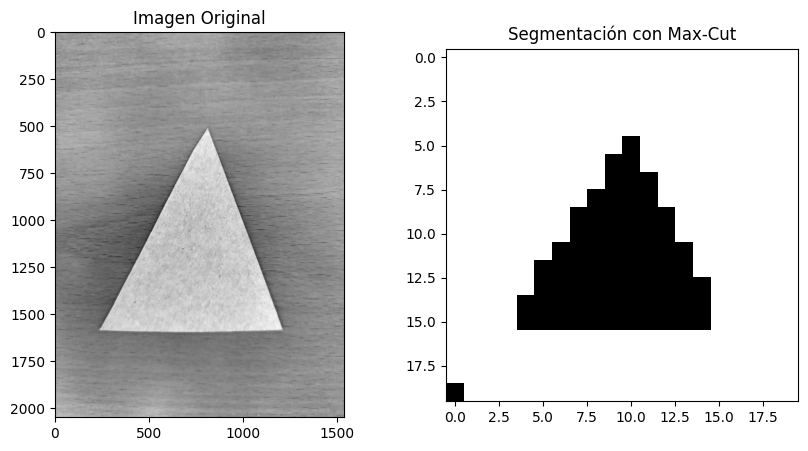

In [6]:
# Construcción del QUBO para Max-Cut 
node_mapping = {node: i for i, node in enumerate(G.nodes)}
num_nodes = len(G.nodes)
qubo_matrix = dok_matrix((num_nodes, num_nodes), dtype=np.float32)

# Matriz de adyacencia invertida para maximización
adj_matrix = -1 * nx.to_scipy_sparse_array(G).toarray()  # Inversión para maximización
# Términos cuadráticos (basados en la matriz de adyacencia)
for i in range(num_nodes):
    for j in range(i + 1, num_nodes):
        weight = adj_matrix[i, j]
        if weight != 0:
            qubo_matrix[i, j] += weight
            qubo_matrix[j, i] += weight

# Término unario: guía según la intensidad (opcional, ajustable)
alpha = 30.0
for node in G.nodes:
    i = node_mapping[node]
    intensity = image_resized[node[0], node[1]]
    qubo_matrix[i, i] += alpha * (2 * intensity - 1)

# Convertir la matriz QUBO a formato numpy y enviarla a QCI
qubo_numpy = qubo_matrix.toarray()
qubo_data = {"file_name": "qubo_data.json", "file_config": {"qubo": {"data": qubo_numpy}}}
try:
    response_json = qclient.upload_file(file=qubo_data)
except Exception as e:
    print(f"Error al subir el archivo a QCI: {e}")
    exit(1)

# Enviar trabajo a QCI
job_body = qclient.build_job_body(
    job_type="sample-qubo",
    qubo_file_id=response_json["file_id"],
    job_params={"device_type": "dirac-1", "num_samples": 2}
)
try:
    job_response = qclient.process_job(job_body=job_body)
except Exception as e:
    print(f"Error al procesar el trabajo en QCI: {e}")
    exit(1)
# Seleccionar la mejor solución
solutions = job_response["results"]["solutions"]
energies = job_response["results"]["energies"]
best_solution = solutions[np.argmin(energies)]
solution_binary_string = [int(best_solution[node_mapping[node]]) for node in G.nodes]


# Decodificación
segmentation_mask = decode_binary_string(solution_binary_string, image_resized.shape[0], image_resized.shape[1])

# Post-procesamiento
labeled_mask, num_features = label(segmentation_mask)
if num_features > 0:
    sizes = np.bincount(labeled_mask.ravel())[1:]
    largest_label = np.argmax(sizes) + 1
    segmentation_mask = (labeled_mask == largest_label).astype(float)

# Visualización
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(image, cmap=plt.cm.gray)
plt.title("Imagen Original")
plt.subplot(1, 2, 2)
plt.imshow(segmentation_mask, cmap=plt.cm.gray)
plt.title("Segmentación con Max-Cut")
plt.show()

2025-05-12 19:48:12 - Dirac allocation balance = 103 s
2025-05-12 19:48:12 - Job submitted: job_id='682234597022694b835c0004'
2025-05-12 19:48:12 - QUEUED
2025-05-12 19:48:15 - RUNNING
2025-05-12 19:49:54 - COMPLETED
2025-05-12 19:49:57 - Dirac allocation balance = 29 s


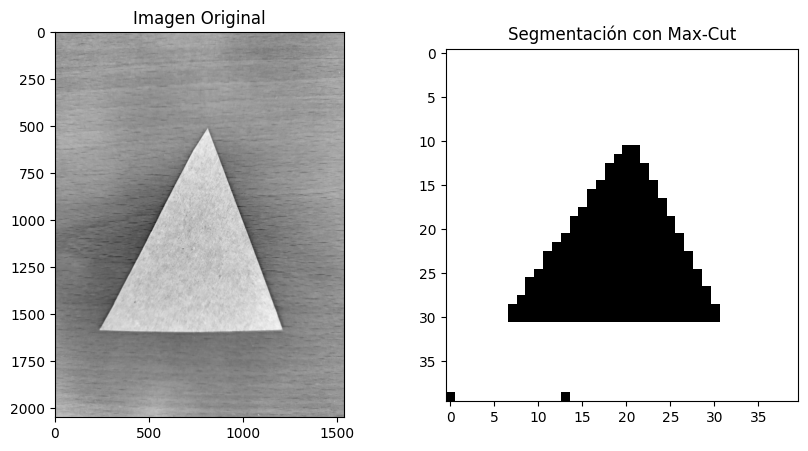

In [13]:
# Construcción del QUBO para Max-Cut 
node_mapping = {node: i for i, node in enumerate(G.nodes)}
num_nodes = len(G.nodes)
qubo_matrix = dok_matrix((num_nodes, num_nodes), dtype=np.float32)

# Matriz de adyacencia invertida para maximización
adj_matrix = -1 * nx.to_scipy_sparse_array(G).toarray()  # Inversión para maximización
# Términos cuadráticos (basados en la matriz de adyacencia)
for i in range(num_nodes):
    for j in range(i + 1, num_nodes):
        weight = adj_matrix[i, j]
        if weight != 0:
            qubo_matrix[i, j] += weight
            qubo_matrix[j, i] += weight

# guía según la intensidad (ajustable)
alpha = 30.0
for node in G.nodes:
    i = node_mapping[node]
    intensity = image_resized[node[0], node[1]]
    qubo_matrix[i, i] += alpha * (2 * intensity - 1)

# Convertir la matriz QUBO a formato numpy y enviarla a QCI
qubo_numpy = qubo_matrix.toarray()
qubo_data = {"file_name": "qubo_data.json", "file_config": {"qubo": {"data": qubo_numpy}}}

try:
    response_json = qclient.upload_file(file=qubo_data)
except Exception as e:
    print(f"Error al subir el archivo a QCI: {e}")
    exit(1)

# Enviar trabajo a QCI
job_body = qclient.build_job_body(
    job_type="sample-qubo",
    qubo_file_id=response_json["file_id"],
    job_params={"device_type": "dirac-1", "num_samples": 1}
)
try:
    job_response = qclient.process_job(job_body=job_body)
except Exception as e:
    print(f"Error al procesar el trabajo en QCI: {e}")
    exit(1)
    
# Seleccionar la mejor solución
solutions = job_response["results"]["solutions"]
energies = job_response["results"]["energies"]
best_solution = solutions[np.argmin(energies)]
solution_binary_string = [int(best_solution[node_mapping[node]]) for node in G.nodes]


# Decodificación
segmentation_mask = decode_binary_string(solution_binary_string, image_resized.shape[0], image_resized.shape[1])# Post-procesamiento

# Post-procesamiento
labeled_mask, num_features = label(segmentation_mask)
if num_features > 0:
    sizes = np.bincount(labeled_mask.ravel())[1:]
    largest_label = np.argmax(sizes) + 1
    segmentation_mask = (labeled_mask == largest_label).astype(float)

# Visualización
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(image, cmap=plt.cm.gray)
plt.title("Imagen Original")
plt.subplot(1, 2, 2)
plt.imshow(segmentation_mask, cmap=plt.cm.gray)
plt.title("Segmentación con Max-Cut")
plt.show()

2025-05-12 19:39:20 - Dirac allocation balance = 182 s
2025-05-12 19:39:21 - Job submitted: job_id='682232457022694b835c0002'
2025-05-12 19:39:21 - RUNNING
2025-05-12 19:39:37 - COMPLETED
2025-05-12 19:39:39 - Dirac allocation balance = 177 s


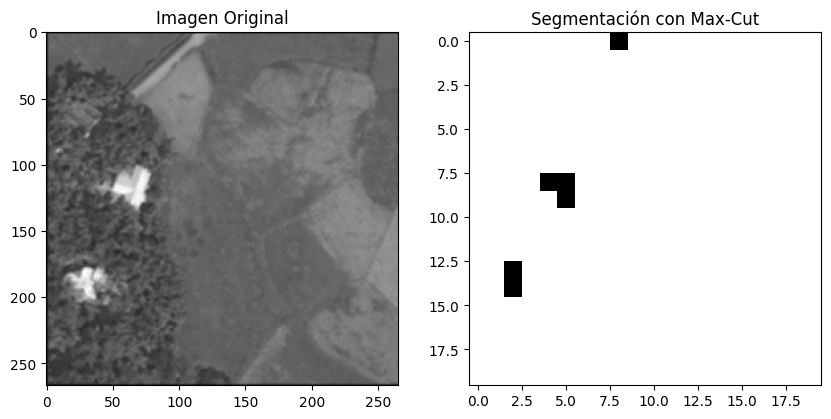

In [8]:
# Construcción del QUBO para Max-Cut 
node_mapping = {node: i for i, node in enumerate(G.nodes)}
num_nodes = len(G.nodes)
qubo_matrix = dok_matrix((num_nodes, num_nodes), dtype=np.float32)

# Matriz de adyacencia invertida para maximización
adj_matrix = -1 * nx.to_scipy_sparse_array(G).toarray()  # Inversión para maximización
# Términos cuadráticos (basados en la matriz de adyacencia)
for i in range(num_nodes):
    for j in range(i + 1, num_nodes):
        weight = adj_matrix[i, j]
        if weight != 0:
            qubo_matrix[i, j] += weight
            qubo_matrix[j, i] += weight

# Término unario: guía según la intensidad (opcional, ajustable)
alpha = 20.0
for node in G.nodes:
    i = node_mapping[node]
    intensity = image_resized[node[0], node[1]]
    qubo_matrix[i, i] += alpha * (2 * intensity - 1)

# Convertir la matriz QUBO a formato numpy y enviarla a QCI
qubo_numpy = qubo_matrix.toarray()
qubo_data = {"file_name": "qubo_data.json", "file_config": {"qubo": {"data": qubo_numpy}}}
try:
    response_json = qclient.upload_file(file=qubo_data)
except Exception as e:
    print(f"Error al subir el archivo a QCI: {e}")
    exit(1)

# Enviar trabajo a QCI
job_body = qclient.build_job_body(
    job_type="sample-qubo",
    qubo_file_id=response_json["file_id"],
    job_params={"device_type": "dirac-1", "num_samples": 1}
)
try:
    job_response = qclient.process_job(job_body=job_body)
except Exception as e:
    print(f"Error al procesar el trabajo en QCI: {e}")
    exit(1)
# Seleccionar la mejor solución
solutions = job_response["results"]["solutions"]
energies = job_response["results"]["energies"]
best_solution = solutions[np.argmin(energies)]
solution_binary_string = [int(best_solution[node_mapping[node]]) for node in G.nodes]


# Decodificación
segmentation_mask = decode_binary_string(solution_binary_string, image_resized.shape[0], image_resized.shape[1])

# Post-procesamiento
labeled_mask, num_features = label(segmentation_mask)
if num_features > 0:
    sizes = np.bincount(labeled_mask.ravel())[1:]
    largest_label = np.argmax(sizes) + 1
    segmentation_mask = (labeled_mask == largest_label).astype(float)

# Visualización
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(image, cmap=plt.cm.gray)
plt.title("Imagen Original")
plt.subplot(1, 2, 2)
plt.imshow(segmentation_mask, cmap=plt.cm.gray)
plt.title("Segmentación con Max-Cut")
plt.show()

C:\Users\carlo\AppData\Local\Temp\ipykernel_14716\3437340264.py:7: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  adj_matrix = -1 * nx.adjacency_matrix(G).todense()  # Inversión para maximización


2025-05-10 14:12:45 - Dirac allocation balance = 486 s
2025-05-10 14:12:45 - Job submitted: job_id='681f42bc7022694b835bffd9'
2025-05-10 14:12:46 - QUEUED
2025-05-10 14:12:48 - RUNNING
2025-05-10 14:14:18 - COMPLETED
2025-05-10 14:14:20 - Dirac allocation balance = 461 s


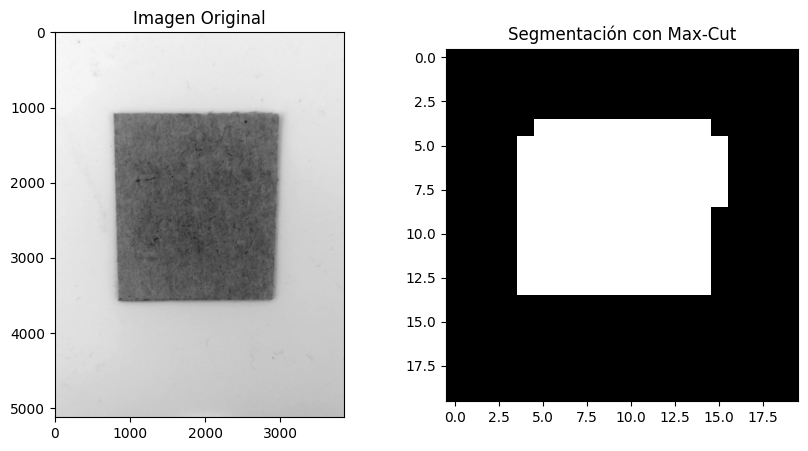

In [13]:
# Construcción del QUBO para Max-Cut 
node_mapping = {node: i for i, node in enumerate(G.nodes)}
num_nodes = len(G.nodes)
qubo_matrix = dok_matrix((num_nodes, num_nodes), dtype=np.float32)

# Matriz de adyacencia invertida para maximización
adj_matrix = -1 * nx.adjacency_matrix(G).todense()  # Inversión para maximización

# Términos cuadráticos (basados en la matriz de adyacencia)
for i in range(num_nodes):
    for j in range(i + 1, num_nodes):
        weight = adj_matrix[i, j]
        if weight != 0:
            qubo_matrix[i, j] += weight
            qubo_matrix[j, i] += weight

# Término unario: guía según la intensidad (opcional, ajustable)
alpha = 10.0
for node in G.nodes:
    i = node_mapping[node]
    intensity = image_resized[node[0], node[1]]
    qubo_matrix[i, i] += alpha * (2 * intensity - 1)

# Convertir la matriz QUBO a formato numpy y enviarla a QCI
qubo_numpy = qubo_matrix.toarray()
qubo_data = {"file_name": "qubo_data.json", "file_config": {"qubo": {"data": qubo_numpy}}}
try:
    response_json = qclient.upload_file(file=qubo_data)
except Exception as e:
    print(f"Error al subir el archivo a QCI: {e}")
    exit(1)

# Enviar trabajo a QCI
job_body = qclient.build_job_body(
    job_type="sample-qubo",
    qubo_file_id=response_json["file_id"],
    job_params={"device_type": "dirac-1", "num_samples": 5}
)
try:
    job_response = qclient.process_job(job_body=job_body)
except Exception as e:
    print(f"Error al procesar el trabajo en QCI: {e}")
    exit(1)

# Seleccionar la mejor solución
solutions = job_response["results"]["solutions"]
energies = job_response["results"]["energies"]
best_solution = solutions[np.argmin(energies)]
solution_binary_string = [int(best_solution[node_mapping[node]]) for node in G.nodes]


# Decodificación
segmentation_mask = decode_binary_string(solution_binary_string, image_resized.shape[0], image_resized.shape[1])

# Post-procesamiento
labeled_mask, num_features = label(segmentation_mask)
if num_features > 0:
    sizes = np.bincount(labeled_mask.ravel())[1:]
    largest_label = np.argmax(sizes) + 1
    segmentation_mask = (labeled_mask == largest_label).astype(float)

# Visualización
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(image, cmap=plt.cm.gray)
plt.title("Imagen Original")
plt.subplot(1, 2, 2)
plt.imshow(segmentation_mask, cmap=plt.cm.gray)
plt.title("Segmentación con Max-Cut")
plt.show()